In [1]:
import openai
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

from dotenv import load_dotenv
import os

load_dotenv()  # Load environment variables from .env file

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [6]:
PART = 'presentation'
# PART = 'QnA'

In [2]:
# import system_message.txt as a string
with open('prompts/system_message.txt', 'r') as file:
    system_message = file.read()

print(system_message)

Context:
You are an advanced AI language model trained to analyze financial documents. Your task is to analyze the last earnings call transcripts before default of companies and extract specific textual features, sentiment scores, and key financial metrics. These features will be used to predict the recovery rate of bonds, defined as the 30-day average bond price after default, issued by these companies.

Objective:
Given the provided earnings call transcript, perform the following tasks:

Extract Financial Sentiment Scores:
Evaluate the financial sentiment expressed throughout the earnings call using the following unique categories:
[Score1] Negative Sentiment (0.00-1.00): Measure the extent of negative financial language (e.g., risks, losses, challenges, declining revenues, increased expenses). A score closer to 1 indicates a highly negative financial tone.
[Score2] Positive Sentiment (0.00-1.00): Assess the presence of positive financial language (e.g., growth, profits, opportunitie

In [90]:
transcripts = pd.read_csv('transcripts/credit_df.csv', delimiter='|')

# count unique transcripts in transcripts['Cleaned_Bankruptcy_Indicators']
print(transcripts['presentation_cleaned'].nunique())

# count rows where presentation_cleaned is ''
print(transcripts['presentation_cleaned'].isnull().sum())

# drop rows where presentation_cleaned is ''
transcripts = transcripts.dropna(subset=['presentation_cleaned'])

# add a number to each transcript based on the 196 unique transcripts
transcripts['transcript_number'] = transcripts['presentation_cleaned'].factorize()[0]

number_transcript = transcripts[['transcript_number', 'presentation_cleaned']].drop_duplicates().sort_values('transcript_number')

number_transcript.head()

193
3


,transcript_number,presentation_cleaned
0,0,"as you know, on september 18th, kellwood recei..."
1,1,"secondly, we're going to be\nallowing one ques..."
2,2,frontier assumes\nno obligation to update this...
3,3,"with me\ntoday are; dick bond, our president a..."
4,4,bob will then\nreview the financial performanc...


In [7]:
transcripts = pd.read_csv('transcripts/credit_df.csv', delimiter='|')

# drop rows where presentation_cleaned is ''
transcripts = transcripts.dropna(subset=[PART])

# add a number to each transcript based on the 196 unique transcripts
transcripts['transcript_number'] = transcripts[PART].factorize()[0]

number_transcript = transcripts[['transcript_number', PART]].drop_duplicates().sort_values('transcript_number')

In [8]:
client = openai.OpenAI(api_key=OPENAI_API_KEY)

output = []

In [9]:
for i in number_transcript[PART]:
    try:
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            temperature=0,
            messages=[
                {"role": "system", "content": system_message},
                {"role": "user", "content": i}
            ]
        )
        output.append(completion.choices[0].message.content)
        print(len(output))
        print(completion.choices[0].message.content)
    except openai.error.OpenAIError as e:
        print(f"An exception occurred: {e}")
        print("Waiting for 1 minute before retrying...")
        time.sleep(60)


1
0.75; 0.25; 0.60; 0.40; 0.30; 0.50; 0.45; 0.55; 0.50; 0.40; 0.35
2
0.75; 0.25; 0.60; 0.40; 0.30; 0.50; 0.45; 0.35; 0.40; 0.30; 0.50
3
0.85; 0.30; 0.70; 0.40; 0.20; 0.60; 0.50; 0.30; 0.40; 0.20; 0.50
4
0.85; 0.30; 0.75; 0.40; 0.20; 0.60; 0.50; 0.45; 0.55; 0.30; 0.40
5
0.75; 0.80; 0.60; 0.70; 0.65; 0.75; 0.70; 0.80; 0.75; 0.70; 0.65
6
0.75; 0.65; 0.70; 0.80; 0.50; 0.60; 0.55; 0.70; 0.60; 0.50; 0.40
7
0.85; 0.30; 0.70; 0.75; 0.60; 0.50; 0.65; 0.40; 0.50; 0.60; 0.55
8
0.75; 0.25; 0.60; 0.40; 0.30; 0.50; 0.45; 0.35; 0.20; 0.30; 0.40
9
0.85; 0.15; 0.70; 0.80; 0.60; 0.40; 0.50; 0.30; 0.20; 0.40; 0.30
10
0.85; 0.40; 0.70; 0.60; 0.50; 0.55; 0.45; 0.50; 0.60; 0.40; 0.30
11
0.85; 0.15; 0.70; 0.60; 0.40; 0.50; 0.30; 0.50; 0.40; 0.20; 0.30
12
0.85; 0.15; 0.80; 0.90; 0.70; 0.60; 0.50; 0.40; 0.30; 0.20; 0.50
13
0.75; 0.25; 0.60; 0.80; 0.50; 0.70; 0.65; 0.70; 0.60; 0.40; 0.50
14
0.85; 0.40; 0.70; 0.75; 0.60; 0.65; 0.50; 0.55; 0.70; 0.60; 0.50
15
0.85; 0.15; 0.70; 0.40; 0.30; 0.20; 0.25; 0.50; 0.30; 

In [10]:
# Initialize the DataFrame with the new columns
output_df = pd.DataFrame(columns=[
    'negative', 'positive', 'uncertainty',
    'liquidity_concerns', 'debt_leverage_stress', 'operational_challenges', 'industry_positioning',
    'asset_quality', 'recovery_strategies', 'legal', 'macroeconomic'
])

# Parse the output list and populate the DataFrame
output_df['negative'] = [float(i.split('; ')[0]) for i in output]
output_df['positive'] = [float(i.split('; ')[1]) for i in output]
output_df['uncertainty'] = [float(i.split('; ')[2]) for i in output]
output_df['liquidity_concerns'] = [float(i.split('; ')[3]) for i in output]
output_df['debt_leverage_stress'] = [float(i.split('; ')[4]) for i in output]
output_df['operational_challenges'] = [float(i.split('; ')[5]) for i in output]
output_df['industry_positioning'] = [float(i.split('; ')[6]) for i in output]
output_df['asset_quality'] = [float(i.split('; ')[7]) for i in output]
output_df['recovery_strategies'] = [float(i.split('; ')[8]) for i in output]
output_df['legal'] = [float(i.split('; ')[9]) for i in output]
output_df['macroeconomic'] = [float(i.split('; ')[10]) for i in output]

# Display the DataFrame
output_df


,negative,positive,uncertainty,liquidity_concerns,debt_leverage_stress,operational_challenges,industry_positioning,asset_quality,recovery_strategies,legal,macroeconomic
0,0.75,0.25,0.60,0.4,0.30,0.50,0.45,0.55,0.50,0.4,0.35
1,0.75,0.25,0.60,0.4,0.30,0.50,0.45,0.35,0.40,0.3,0.50
2,0.85,0.30,0.70,0.4,0.20,0.60,0.50,0.30,0.40,0.2,0.50
3,0.85,0.30,0.75,0.4,0.20,0.60,0.50,0.45,0.55,0.3,0.40
4,0.75,0.80,0.60,0.7,0.65,0.75,0.70,0.80,0.75,0.7,0.65
...,...,...,...,...,...,...,...,...,...,...,...
191,0.85,0.30,0.70,0.6,0.40,0.50,0.45,0.55,0.60,0.5,0.40
192,0.20,0.80,0.30,0.7,0.60,0.75,0.85,0.90,0.80,0.7,0.60
193,0.20,0.80,0.30,0.7,0.60,0.80,0.75,0.85,0.70,0.6,0.50
194,0.85,0.15,0.70,0.6,0.40,0.50,0.55,0.30,0.45,0.2,0.50


In [11]:
output_df['transcript_number'] = output_df.index

# merge output_df with transcripts on 'transcript_number' and index
transcripts = pd.merge(transcripts,
                          output_df,
                          on='transcript_number',
                          how='left')

checkpoint = transcripts.copy()

In [151]:
# save checkpoint as csv
checkpoint.to_csv('transcripts/LLM_outputs_QnA.csv', index=False)
checkpoint = pd.read_csv('transcripts/LLM_outputs_QnA.csv')

In [12]:
# List of selected supporting features
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

llm_labels = ['negative', 'positive', 'uncertainty',
    'liquidity_concerns', 'debt_leverage_stress', 'operational_challenges', 'industry_positioning',
    'asset_quality', 'recovery_strategies', 'legal', 'macroeconomic']

# Select the supporting features, nlp_lables, and RR from final_df
final_df = checkpoint[['Date'] 
                    #+ supporting_features_1
                    #+ supporting_features_2
                    + llm_labels 
                    + ['RR']]

# replace #DIV/0! & Nan with 0
# Replace '#DIV/0!' with NaN
final_df.replace('#DIV/0!', np.nan, inplace=True)
final_df = final_df.fillna(0)

# make sure all values are numeric except for the Date column
final_df = final_df.apply(pd.to_numeric, errors='ignore')

final_df.head()

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,Date,negative,positive,uncertainty,liquidity_concerns,debt_leverage_stress,operational_challenges,industry_positioning,asset_quality,recovery_strategies,legal,macroeconomic,RR
0,2006-12-01,0.75,0.25,0.60,0.4,0.30,0.50,0.45,0.55,0.50,0.4,0.35,29.023972
1,2007-11-06,0.75,0.25,0.60,0.4,0.30,0.50,0.45,0.35,0.40,0.3,0.50,8.869420
2,2008-01-25,0.85,0.30,0.70,0.4,0.20,0.60,0.50,0.30,0.40,0.2,0.50,33.210455
3,2008-01-28,0.85,0.30,0.75,0.4,0.20,0.60,0.50,0.45,0.55,0.3,0.40,11.875000
4,2008-01-30,0.75,0.80,0.60,0.7,0.65,0.75,0.70,0.80,0.75,0.7,0.65,18.340000


In [13]:
# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR', 'Date']), final_df.drop(columns=['RR', 'Date'])

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     71.19
Date:                Fri, 04 Oct 2024   Prob (F-statistic):          3.00e-119
Time:                        14:57:28   Log-Likelihood:                -4725.1
No. Observations:                1075   AIC:                             9474.
Df Residuals:                    1063   BIC:                             9534.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     45

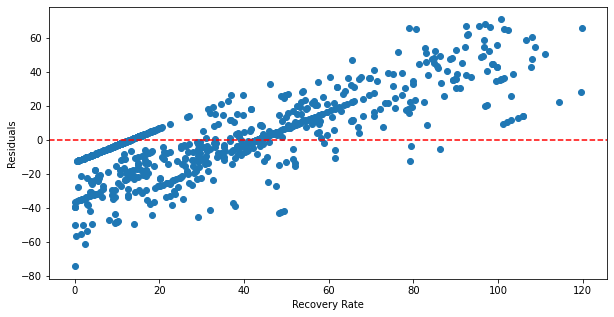

In [14]:
# LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [15]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

                  Features         VIF
0                    const  236.046295
4       liquidity_concerns    7.490463
5     debt_leverage_stress    6.044654
10                   legal    5.575318
9      recovery_strategies    5.080278
2                 positive    5.077135
1                 negative    5.045106
3              uncertainty    4.594279
8            asset_quality    4.035097
6   operational_challenges    2.844311
11           macroeconomic    2.758117
7     industry_positioning    2.697690


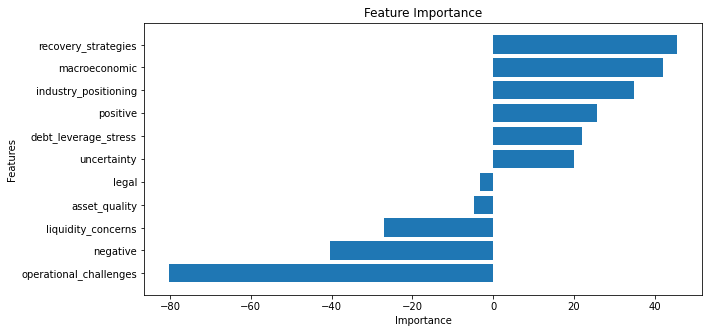

In [16]:
# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()